# Timeseries modeling with RuneScape data!

Greetings for the reader! In this notebook I will be performing some linear and non-linear timeseries analysis using Python. The analysis will be performed with real life data gathered from my current favourite videogame, Old School RuneScape(OSRS).

Little context for the dataset before we start. OSRS is MMOPRG style of game that has existed in different forms since 2001 and today the game has roughly 300 thousand daily players. In OSRS there are multiple ways to upgrade your account, one of which is done by collecting all the different items the game has available. There are thousands of items inside the game from which majority are tradable between players. The main trading place is called Grand Exchange(GE) which works like stock market: player wanting to buy certain item puts offer in for how much they are willing to pay for the said item. If another player wants to sell his item, he puts offer in for how many coins he wants in return for said item. If these offers match, transaction goes through. 

The data is gathered from oldschool.runescape.wiki, which is basically Wikipedia just for this game. The data I will be using is collected right at the time of analysis, so running the code wont replicate all my steps.

Without further ado, let's dive in!

In [1]:
#load some useful libraries and functions
from matplotlib import pyplot as plt
import numpy as np
from io import StringIO
import requests
import pandas as pd
import webbrowser
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit

In [4]:
# get the URL of the data, timestep=1h means its hourly average data and id refers to item id
url = "https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=1h&id=1127"
#open the url, good idea to check there are no issues
webbrowser.open(url)
# Send a GET request to the URL
response = requests.get(url)

# Check if the response was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data
    
    # Extract the 'data' array if present in the response
    if 'data' in data:
        prices = data['data']
        
        # Convert the relevant fields to a DataFrame
        df = pd.DataFrame([
            {
                'timestamp': pd.to_datetime(entry['timestamp'], unit='s'),
                'avgLowPrice': entry.get('avgLowPrice', np.nan),
                'avgHighPrice': entry.get('avgHighPrice', np.nan)
            }
            for entry in prices
        ])
        
        # Set the timestamp as the index for time series format
        df.set_index('timestamp', inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.asfreq('H')
        
        # Fill missing values with the average of the value before and after
        df['avgHighPrice'] = df['avgHighPrice'].interpolate(method='linear')
        df['avgLowPrice'] = df['avgLowPrice'].interpolate(method='linear')
        #drop remaining rows with missing values(mainly from first and last row)
        df=df.dropna()
        
        
        print("Data as time series DataFrame with missing values handled:")
        print(df)
    else:
        print("No 'data' key found in the response.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

Data as time series DataFrame with missing values handled:
                     avgLowPrice  avgHighPrice
timestamp                                     
2024-12-03 02:00:00      38513.0       38606.0
2024-12-03 03:00:00      38633.0       38646.0
2024-12-03 04:00:00      38545.0       38626.0
2024-12-03 05:00:00      38669.0       38665.0
2024-12-03 06:00:00      38649.0       38647.0
...                          ...           ...
2024-12-18 03:00:00      38507.0       38508.0
2024-12-18 04:00:00      38482.0       38511.0
2024-12-18 05:00:00      38527.0       38511.0
2024-12-18 06:00:00      38509.0       38511.0
2024-12-18 07:00:00      38516.0       38512.0

[366 rows x 2 columns]


Dataset contains of 366 rows of hourly data  which means just over 15 days of hourly datapoints. Dataset starts December 3rd at two on the morning and ends on December 18th at seven. The imminent issue with the dataset in timeseries context is that it's quite small in size. only little over 2 weeks of hourly data is not often enough, especially with this complex dataset. That is however what we have to deal with and I'm gonna make themost out of it!

In the data set there are 2 different average prices, high and low. I will take one final average from these 2 columns. This will hopefully ensure more reliable price information as potential spikes/errors in data gathering process are not so strong in the price information.


In [5]:
df['avgPrice'] = df.mean(axis=1)


print(df)

                     avgLowPrice  avgHighPrice  avgPrice
timestamp                                               
2024-12-03 02:00:00      38513.0       38606.0   38559.5
2024-12-03 03:00:00      38633.0       38646.0   38639.5
2024-12-03 04:00:00      38545.0       38626.0   38585.5
2024-12-03 05:00:00      38669.0       38665.0   38667.0
2024-12-03 06:00:00      38649.0       38647.0   38648.0
...                          ...           ...       ...
2024-12-18 03:00:00      38507.0       38508.0   38507.5
2024-12-18 04:00:00      38482.0       38511.0   38496.5
2024-12-18 05:00:00      38527.0       38511.0   38519.0
2024-12-18 06:00:00      38509.0       38511.0   38510.0
2024-12-18 07:00:00      38516.0       38512.0   38514.0

[366 rows x 3 columns]


Dataset is ready and moving forward I will using avgPrice column as the interesting.

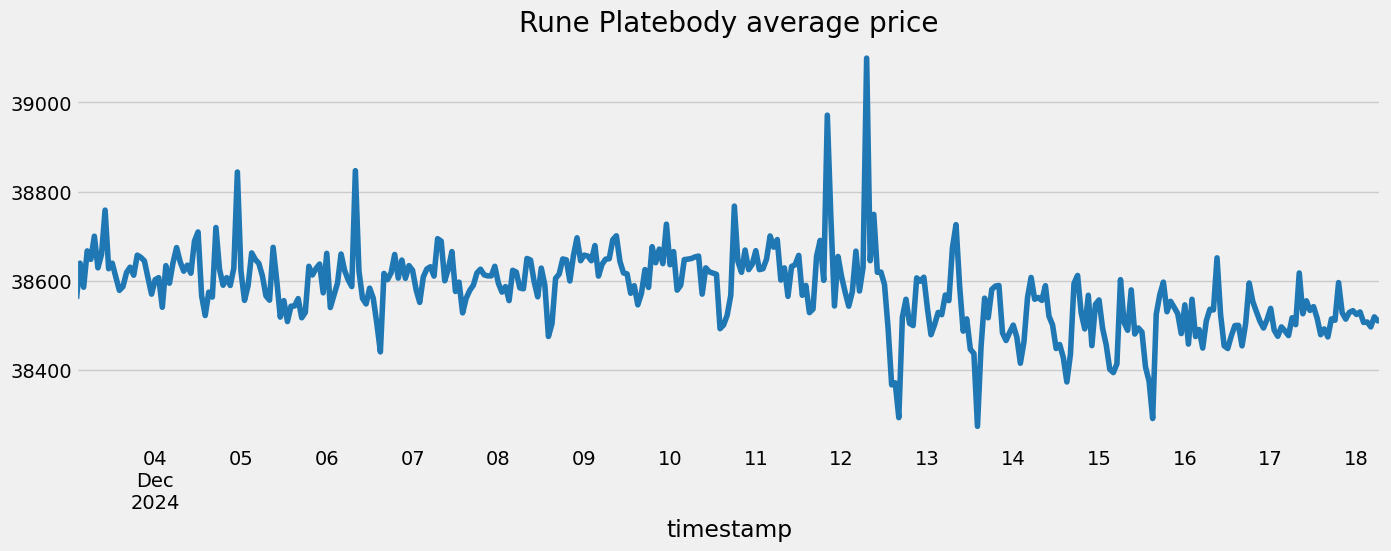

In [6]:
# Plot the time-series data on avgPrice
df['avgPrice'].plot(
        figsize=(15, 5),
        color=color_pal[0],
        title='Rune Platebody average price')
plt.show()

The item I chose for this analysis is Rune Platebody, that is best available bodyarmour in OSRS basegame. Today, apart from the base game, Rune platebody is not so useful anymore as there are multiple better options in the same price bracket. The price of this item is mostly driven by the high alchemy value it has. Rune Platebody has high alchemy value of 39000, so usually price doesn't go above nor too much below that. In the plot above we see one price spike going above 39000 which might due multiple reasons.

From the plot above we can see pretty stable timeseries with mean just under 38600. There are a few spikes here and there but variance seems pretty constant over the time. There are no clear trends and by only looking the graph it's impossible to tell if there are any seasonality.

Lets do some decomposing and see how trends and seasonality looks. To achieve this I will be using STL function.


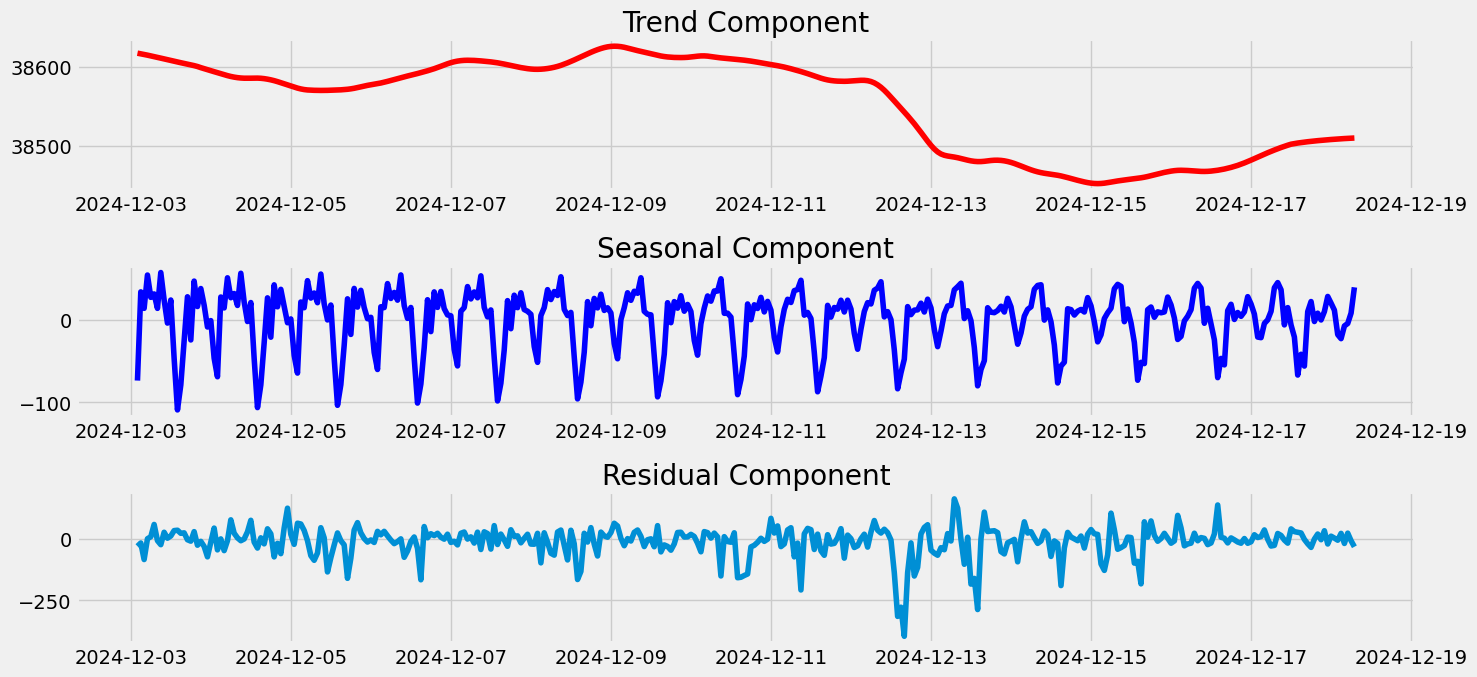

In [18]:
stl = STL(df['avgLowPrice'],seasonal=25, low_pass=25, robust=True) 
result = stl.fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(df.index, result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(df.index, result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(df.index, result.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

From the decompose we can see that trend seems pretty random in this dataset, atleast as a function of time. This is expected based on the visual inspection of the timeseries.

Seasonal component follows 24 hour cycles and it evolves little bit towards the end. Residual component has no clear cycle or trend which is good. 

Next I want to split the data for training and testing. For the above observed seasonality I think 24 hour test set is fine although ambitious with such small train data size.

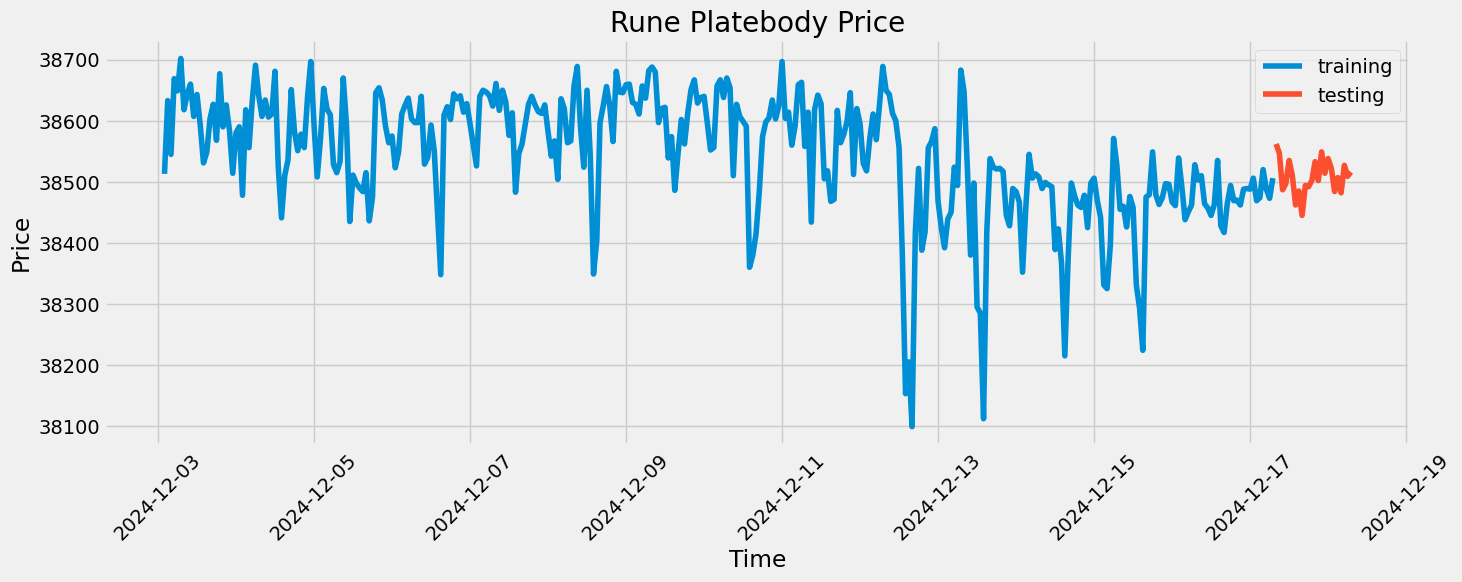

In [20]:
# splitting
train = df['avgLowPrice'][:-24]
test = df['avgLowPrice'][-24:]

plt.figure(figsize=(15,5))
plt.plot(train,label='training')
plt.plot(test, label='testing')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation = 45)
plt.title('Rune Platebody Price')
plt.legend()
plt.show()

Same plot but training and testing is now separated!

Next I want to build my model with training data only. In timeseries forecasting it's important to make sure timeseries is stationary before starting to modeling it. Most of the timeseries theoretical results hold under the assumption that data is stationary. to test if my data is stationary, I willuse Augmented Dickey-Fuller -test.

In [21]:
# Stationary test
adft = adfuller(train)

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -2.494855              Test Statistics
1    0.116731                      p-value
2   10.000000             No. of lags used
3  331.000000  Number of observations used
4   -3.450262          critical value (1%)
5   -2.870312          critical value (5%)
6   -2.571443         critical value (10%)


Test gives me P-value=0.116731 which is larger than the usual 0.05 threshold.Therefore I will conclude that my timeseries is not stationary and will require some transformation to become stationary. My first idea is to use differencing, that is, to take difference from previous value in timeseries and use that as new timeseries. I will use ndiffs and nsdiffs functions to check if this is appropriate.

In [22]:
print("Differencing required is:",ndiffs(train))
print("Seasonal differencing required is:",nsdiffs(train,m=24))

Differencing required is: 1
Seasonal differencing required is: 0


These functions suggests taking one difference to ensure better stationarity so I will just do that.

In [23]:

#simple differencing
  
train_data_prop = train.diff(periods=1)
train_data_prop=train_data_prop.dropna()


adft = adfuller(train_data_prop)

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -1.112581e+01              Test Statistics
1  3.376537e-20                      p-value
2  9.000000e+00             No. of lags used
3  3.310000e+02  Number of observations used
4 -3.450262e+00          critical value (1%)
5 -2.870312e+00          critical value (5%)
6 -2.571443e+00         critical value (10%)


ADF-test now shows significantly smaller p-value which is good. Lets plot this new time series and see how it looks:

timestamp
2024-12-03 03:00:00    120.0
2024-12-03 04:00:00    -88.0
2024-12-03 05:00:00    124.0
2024-12-03 06:00:00    -20.0
2024-12-03 07:00:00     53.0
                       ...  
2024-12-17 03:00:00      5.0
2024-12-17 04:00:00     46.0
2024-12-17 05:00:00    -32.0
2024-12-17 06:00:00    -15.0
2024-12-17 07:00:00     33.0
Freq: H, Name: avgLowPrice, Length: 341, dtype: float64


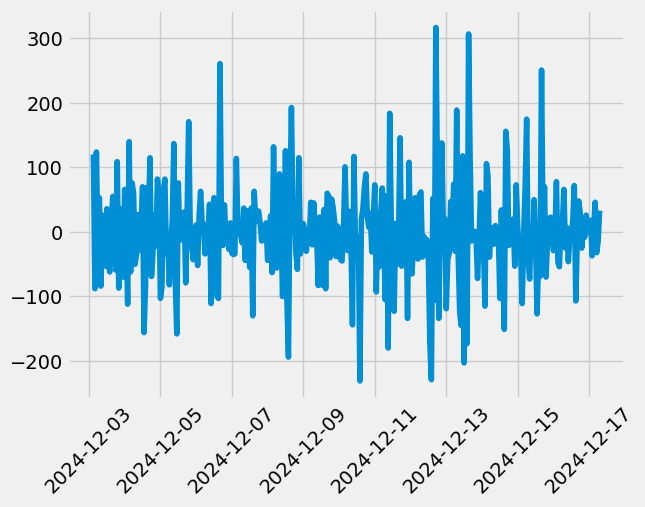

In [24]:
print(train_data_prop)

plt.plot(train_data_prop)
plt.xticks(rotation = 45)
plt.show()

Visual inspection shows that the differenced timeseries does look like its reliably more stationary now. Timeseries has mean roughly at 0 and its variance looks pretty constant over the time. 

With the differenced timeseries at hand, lets look autocorrelation and partial autocorrelation for it!

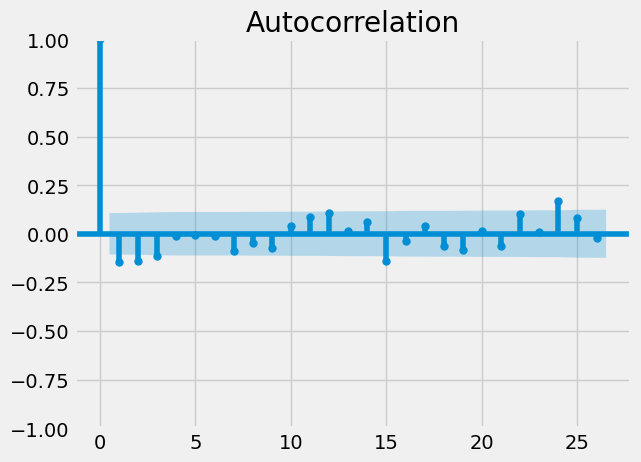

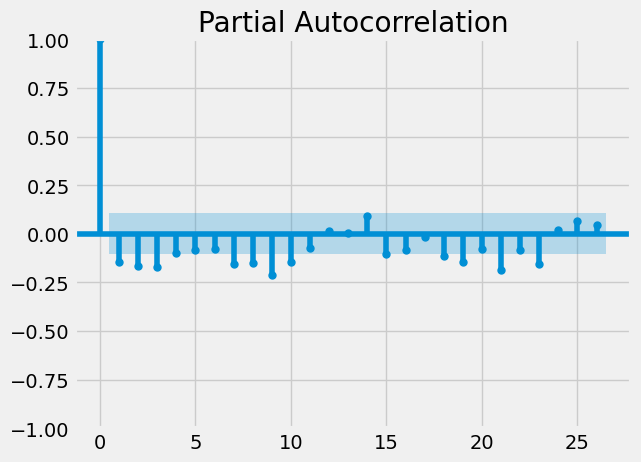

In [25]:
sm.graphics.tsa.plot_acf(train_data_prop);
sm.graphics.tsa.plot_pacf(train_data_prop);

Autocorrelation inspection shows that there are notable autocorrelation left in the timeseries. There are slight jumps in Autocorrelation-plot for 24th lag which is interesting. From ACF-plot we can observe that first 2 lags are clearly out of the confidence intervals which would suggest MA(2) model. From PACF-plot we observe that there are handful of lags outside the confidence intervals. The shape suggests most prominently AR(3) model.

I will try some different ideas to figure out the model: I will fit the SARIMA model with (3,1,2)(1,0,1,24) parameters as this is most promising accoridng to the plots above. I will try basic Arima(3,1,2) model aswell and see how much work does the seasonal component do. Lastly I will also use auto_arima function to see what it would suggest that one. auto_arima is useful in this case especially, since correlation plots were not too clear on the potential parameters. This will hopefully leave me with 3 different models to choose from.

In [130]:
# SARIMA with (3,1,2)(0,0,1,24)
model_sarima = sm.tsa.SARIMAX(endog=train, order=(3,1,2), seasonal_order=(1,0,1,24))
model_fit_sarima = model_sarima.fit()

model_fit_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          avgLowPrice   No. Observations:                  342
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 24)   Log Likelihood               -1903.457
Date:                              Wed, 18 Dec 2024   AIC                           3822.913
Time:                                      14:25:35   BIC                           3853.568
Sample:                                  12-03-2024   HQIC                          3835.127
                                       - 12-17-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4446      0.182     -2.436      0.015      -0.802      -0.087
ar.L2          0.3966      0.098      4.060      0.000       0.205       0.588
ar.L3         -0.0639      0.053     -1.206      0.228      -0.168       0.040
ma.L1         -0.0243      0.178     -0.136      0.891      -0.373       0.324
ma.L2         -0.8663      0.173     -5.018      0.000      -1.205      -0.528
ar.S.L24       0.9202      0.048     18.989      0.000       0.825       1.015
ma.S.L24      -0.7673      0.091     -8.390      0.000      -0.947      -0.588
sigma2      3911.1061    226.806     17.244      0.000    3466.574    4355.638
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               110.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
# ARIMA(3,1,2) without seasonal term
model_arima=ARIMA(train, order=(3,1,2))
model_fit_arima=model_arima.fit()

model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            avgLowPrice   No. Observations:                  342
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1924.291
Date:                Wed, 18 Dec 2024   AIC                           3860.582
Time:                        14:23:32   BIC                           3883.573
Sample:                    12-03-2024   HQIC                          3869.742
                         - 12-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2956      0.122     -2.432      0.015      -0.534      -0.057
ar.L2          0.5055      0.080      6.330      0.000       0.349       0.662
ar.L3         -0.1125      0.049     -2.291      0.022      -0.209      -0.016
ma.L1         -0.0281      0.117     -0.241      0.810      -0.257       0.201
ma.L2         -0.8880      0.116     -7.643      0.000      -1.116      -0.660
sigma2      4569.6748    253.544     18.023      0.000    4072.738    5066.612
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               124.16
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
#auto_arima function
model_auto = auto_arima(train,seasonal=True,start_p=1,start_q=1,max_p=5,max_q=5,d=1,start_P=0,start_Q=0, max_P=2,max_Q=2,
                        D=0,
                      m=24,
                      trace=True,max_order=None,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model_fit_auto= model_auto.fit(train)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=3859.882, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=3920.973, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3907.887, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3905.330, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=3918.973, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=3843.616, Time=1.15 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=3827.346, Time=4.39 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=3821.153, Time=6.88 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=3820.399, Time=1.63 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=3849.249, Time=1.05 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=3821.277, Time=7.40 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=3837.206, Time=4.61 sec
 ARIMA(1,1,1)(2,0,2)[24] intercept   : AIC=3823.005, Time=8.17 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(1,0,1)[24]

In [129]:
model_fit_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  342
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -1904.320
Date:                            Wed, 18 Dec 2024   AIC                           3818.639
Time:                                    14:24:06   BIC                           3837.799
Sample:                                12-03-2024   HQIC                          3826.273
                                     - 12-17-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4591      0.044     10.366      0.000       0.372       0.546
ma.L1         -0.9488      0.018    -51.287      0.000      -0.985      -0.913
ar.S.L24       0.9231      0.041     22.542      0.000       0.843       1.003
ma.S.L24      -0.7712      0.078     -9.849      0.000      -0.925      -0.618
sigma2      3933.6383    216.807     18.143      0.000    3508.704    4358.573
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               103.02
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We now have 3 models to try out: Arima(3,1,2), Sarima(3,1,2)(1,0,1){24} and ARIMA(1,1,1)(1,0,1){24}, which came as best model from auto_arima function. Information criteria suggests that best model is auto_arima having the smallest information criteria in all models.


Lets use these to forecast and check which one fits the test_data best!


In [131]:
forecast_sarima = model_fit_sarima.forecast(steps=24)
forecast_arima = model_fit_arima.forecast(steps=24)
forecast_auto = model_fit_auto.predict(n_periods=24)

#calculating RMSE
sarima_rmse=mean_squared_error(y_true=test.values, y_pred=forecast_sarima, squared=False)
arima_rmse=mean_squared_error(y_true=test.values, y_pred=forecast_arima, squared=False)
auto_rmse=mean_squared_error(y_true=test.values, y_pred=forecast_auto, squared=False)

print("Sarima model RMSE is:", sarima_rmse)
print("Arima model RMSE is:", arima_rmse)
print("Auto_arima model RMSE is:", auto_rmse)

Sarima model RMSE is: 52.46497227498208
Arima model RMSE is: 40.72307040504819
Auto_arima model RMSE is: 54.391000469115106


From RMSE point of view the best model is close call between Sarima and Arima models with Sarima taking the edge.
Lets plot the predictions versus the test set to see visually how the models did.

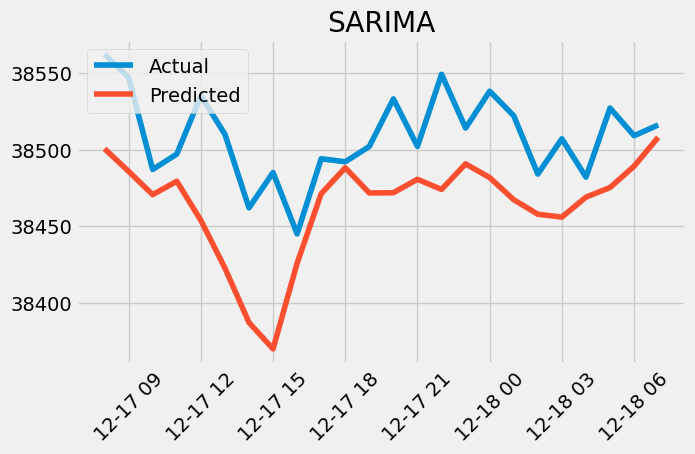

In [132]:
#plotting SARIMA forecast
prediction = pd.DataFrame(forecast_sarima, index=test.index)
prediction.columns = ['predicted_value']
prediction

# Plot prediction against test and training trends 

plt.figure(figsize=(7,4))
#plt.plot(train, label="Training")
plt.plot(test, label="Actual")
plt.plot(prediction, label="Predicted")
plt.title('SARIMA')
plt.xticks(rotation = 45)
plt.legend(loc='upper left')
plt.show()

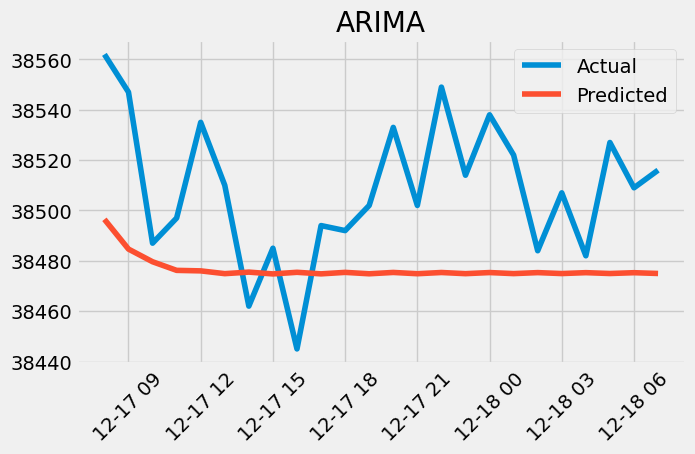

In [133]:

prediction_arima = pd.DataFrame(forecast_arima, index=test.index)
prediction_arima.columns = ['predicted_value']
prediction_arima
# Plot prediction against test and training trends 

plt.figure(figsize=(7,4))
#plt.plot(train, label="Training")
plt.plot(test, label="Actual")
plt.plot(prediction_arima, label="Predicted")
plt.title('ARIMA')
plt.xticks(rotation = 45)
plt.legend(loc='upper right')
plt.show()

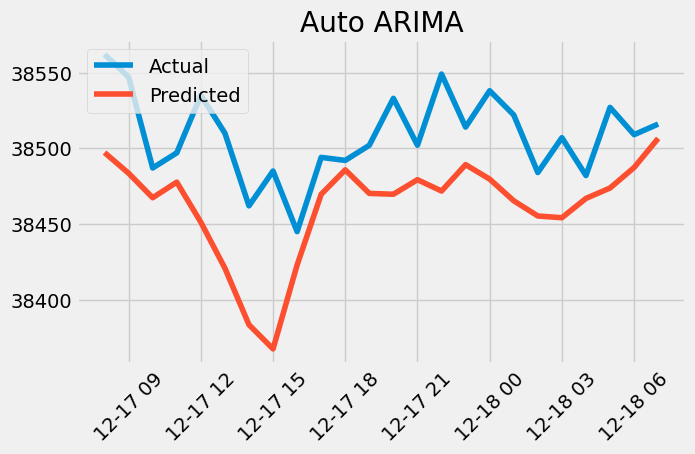

In [134]:
#plotting SARIMA forecast
prediction_auto = pd.DataFrame(forecast_auto, index=test.index)
prediction_auto.columns = ['predicted_value']
prediction_auto

# Plot prediction against test and training trends 

plt.figure(figsize=(7,4))
plt.title('Auto ARIMA')
#plt.plot(train, label="Training")
plt.plot(test, label="Actual")
plt.plot(prediction_auto, label="Predicted")
plt.xticks(rotation = 45)
plt.legend(loc='upper left')
plt.show()

Visual inspection reveals that the models I have created have not been too great for this problem. They don't catch the movements of real data too well. Looking purely at shapes of these predictions the best ones look to be auto_arima and Sarima since tehy show similar shape as the actual test set values. Unfortunately that model also returned the worse RMSE-scores out of these three models. It looks like Arima-family is not the best when it comes to this dataset. 

But we don't give up there!. Next I want to try out little more complicated model and apply exponential smoothing to my dataset. I will apply the Holt-Winter’s Seasonal Smoothing(HWSS) and see if we get any better model.


In [125]:
from statsmodels.tsa.api import ExponentialSmoothing

forecast_period = 24

# Fit data 
model_HWSS = ExponentialSmoothing(
    train,
    seasonal_periods=24,
    trend="add",
    damped_trend=False,
    seasonal="add",
).fit()

# Forecast next 5 periods
forecast_HWSS = model_HWSS.forecast(forecast_period)

HWSS_rmse=mean_squared_error(y_true=test.values, y_pred=forecast_HWSS, squared=False)

print("HWSS model RMSE is:", HWSS_rmse)

model_HWSS.summary()

HWSS model RMSE is: 69.62972831670193


Dep. Variable:,avgLowPrice,No. Observations:,342
Model:,ExponentialSmoothing,SSE,1407519.758
Optimized:,True,AIC,2902.305
Trend:,Additive,BIC,3009.680
Seasonal:,Additive,AICC,2908.286
Seasonal Periods:,24,Date:,"Wed, 18 Dec 2024"
Box-Cox:,False,Time:,14:22:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2320946,alpha,True
smoothing_trend,0.0153359,beta,True


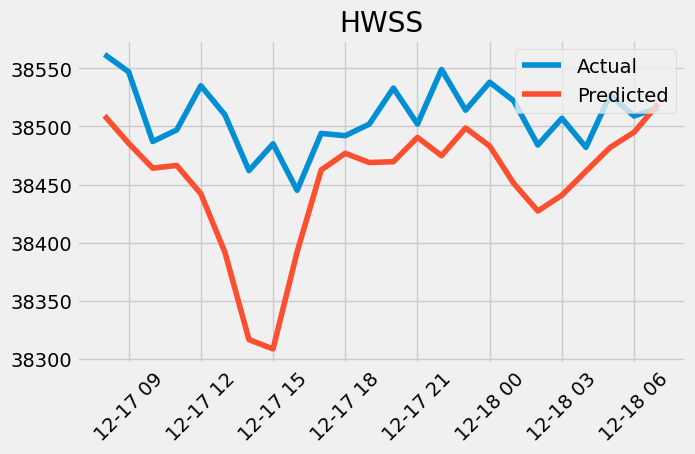

In [124]:
prediction_HWSS = pd.DataFrame(forecast_HWSS, index=test.index)
prediction_HWSS.columns = ['predicted_value']

# Plot prediction against test and training trends 

plt.figure(figsize=(7,4))
#plt.plot(train, label="Training")
#plt.plot(model_HWSS.fittedvalues, label="Fitted model")
plt.plot(test, label="Actual")
plt.plot(prediction_HWSS, label="Predicted")
plt.title('HWSS')
plt.xticks(rotation = 45)
plt.legend(loc='upper right')
plt.show()

Plot above shows similar characteristics than with earlier Arima models. It's interesting that each of these models predict big drop in price at 13-15 o'clock for the 17th day. This drop didn't happen in actual data, atleast not as severe as that, and it would be interesting to dive in why are these models suggesting this drop. 

Nonetheless, HWSS model is our best model so far in terms on information criteria beating the earlier models while having the worst RMSE value. Funny how that sometimes works!

# Timeseries analysis with machine learning

Machine learning is getting more and more important in every data task imaginable. Applying machine learning concepts to timeseries analysis is just another step in making predictive models more accurate. In what follows I will be using XGBoost algorhitm to see if I can find better model that way.

As a reminder, lets plot the dataset once more.

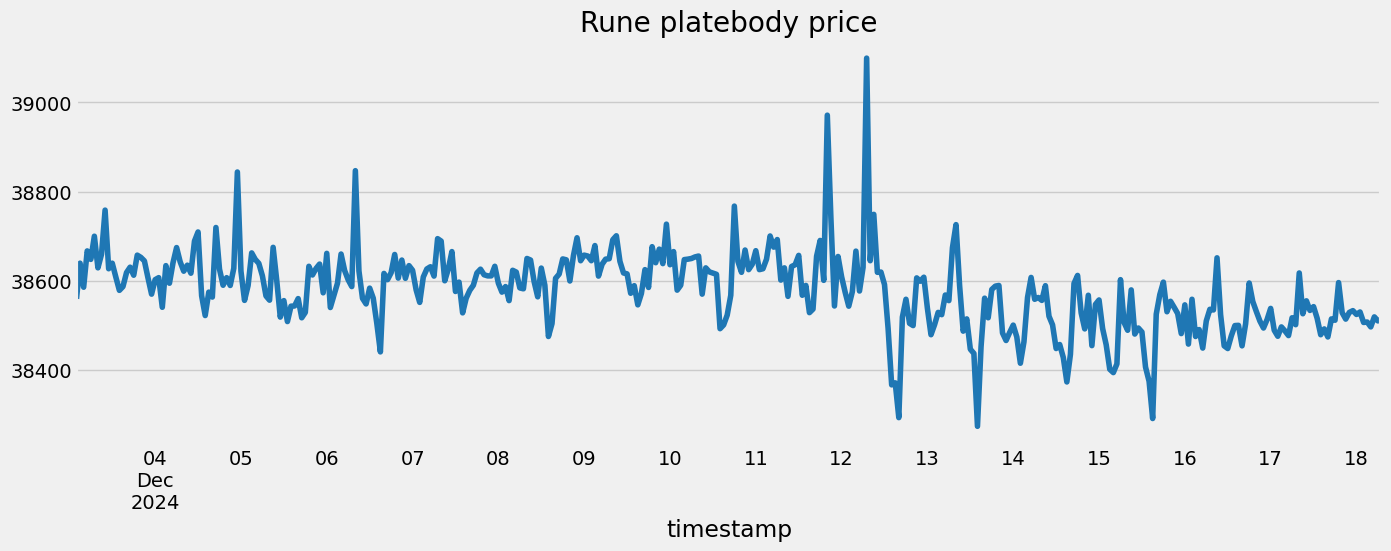

In [135]:
df['avgPrice'].plot(
        figsize=(15, 5),
        color=color_pal[0],
        title='Rune platebody price')
plt.show()

I will start by creating several features to use in XGBoost. As my dataset is relatively short in observations there are not much to choose from. Features I will be using are hour of the day,day of week and binary variable for weekend. I will also use lag feature with 24 hour lagged value.

In [136]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['weekend']=[1 if x>4  else 0 for x in df['dayofweek']]
    return df

df = create_features(df)

def add_lags(df):
    target_map = df['avgPrice'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('24 hours')).map(target_map)
    return df
df = add_lags(df)

print(df)

                     avgLowPrice  avgHighPrice  avgPrice  hour  dayofweek  \
timestamp                                                                   
2024-12-03 02:00:00      38513.0       38606.0   38559.5     2          1   
2024-12-03 03:00:00      38633.0       38646.0   38639.5     3          1   
2024-12-03 04:00:00      38545.0       38626.0   38585.5     4          1   
2024-12-03 05:00:00      38669.0       38665.0   38667.0     5          1   
2024-12-03 06:00:00      38649.0       38647.0   38648.0     6          1   
...                          ...           ...       ...   ...        ...   
2024-12-18 03:00:00      38507.0       38508.0   38507.5     3          2   
2024-12-18 04:00:00      38482.0       38511.0   38496.5     4          2   
2024-12-18 05:00:00      38527.0       38511.0   38519.0     5          2   
2024-12-18 06:00:00      38509.0       38511.0   38510.0     6          2   
2024-12-18 07:00:00      38516.0       38512.0   38514.0     7          2   

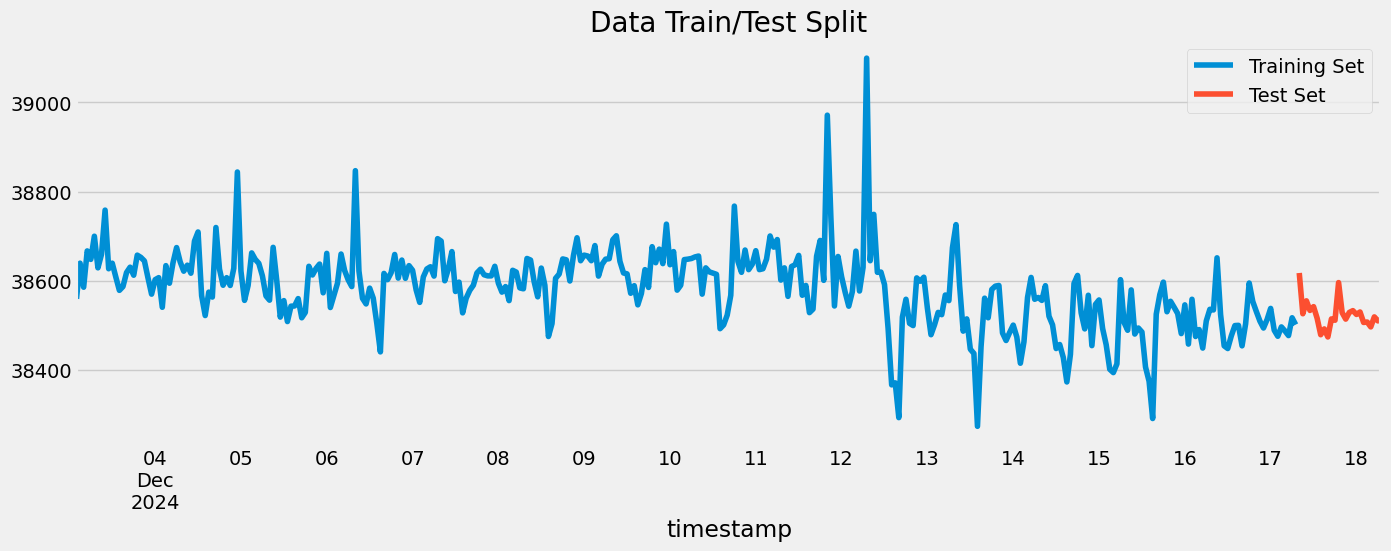

In [137]:
#Splitting the data again
train_data = df[:-24]
test_data = df[-24:]

fig, ax = plt.subplots(figsize=(15, 5))
train_data['avgPrice'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data['avgPrice'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

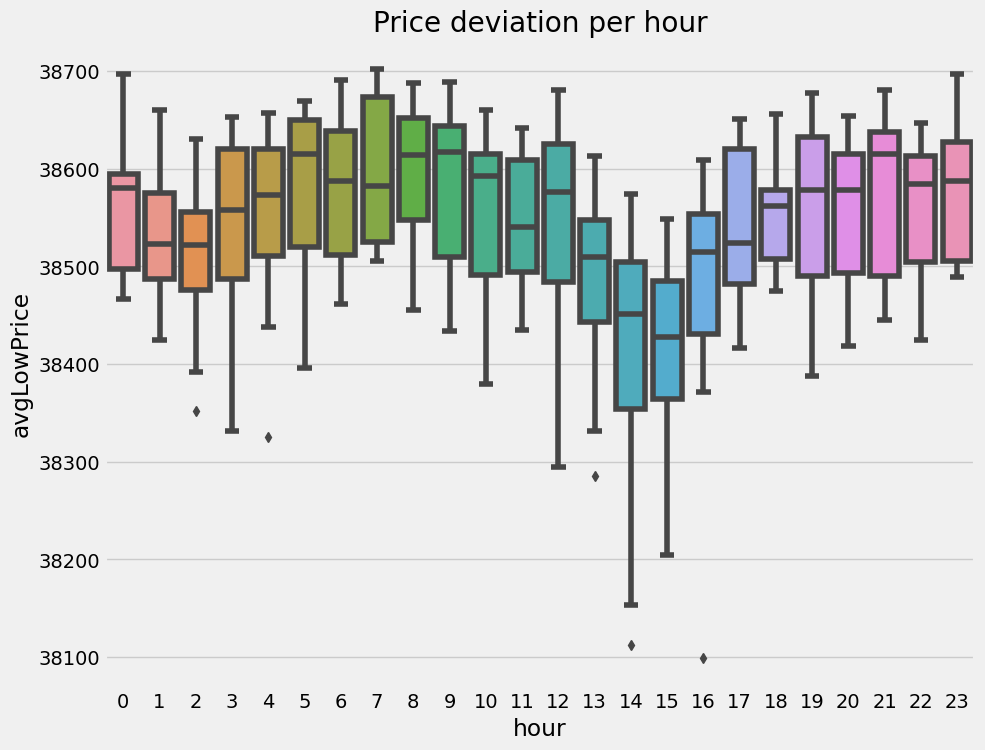

In [138]:
#visualizing some of the features
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='avgLowPrice')
ax.set_title('Price deviation per hour')
plt.show()

The plot above shows price development throughout the day. This plot gives some interesting insights for example on the earlier models: The plot shows that price values are usually at their lowest around hours 13-15 and this is part of why we saw such a huge drop in prediction valeus earlier.

We can also spot some potential outliers here, especially interesting case is that one price at hour 16 that is significantly lower than other values at that hour. For purpose of this notebook I'm not going to dive in for that specific value or try to correct it.



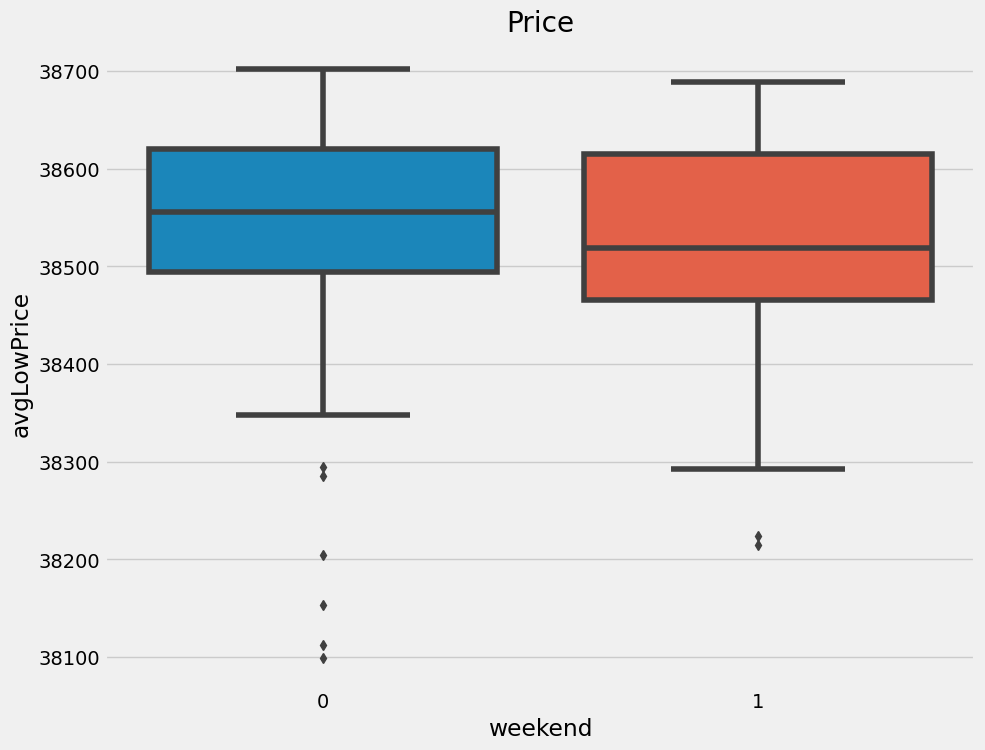

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekend', y='avgLowPrice')
ax.set_title('Price')
plt.show()

For weekend feature there is not much to say, there is no clear distinction between these values.

Next we start to fit the model. I will be using some TimeSeriesplit function to do some cross validation on my dataset. This part of the notebook is little bit of wasteful as Im not going into hyperparemeter tuning but its still fine to show the idea.

In [140]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24, gap=2)
train_data = train_data.sort_index()

For the size of my timeseries I will be using pretty moderate values on the split as my dataset is pretty small. Number of splits will be 3, size on all folds is 24 and gap between is 2. Lets visualize how the folds work.

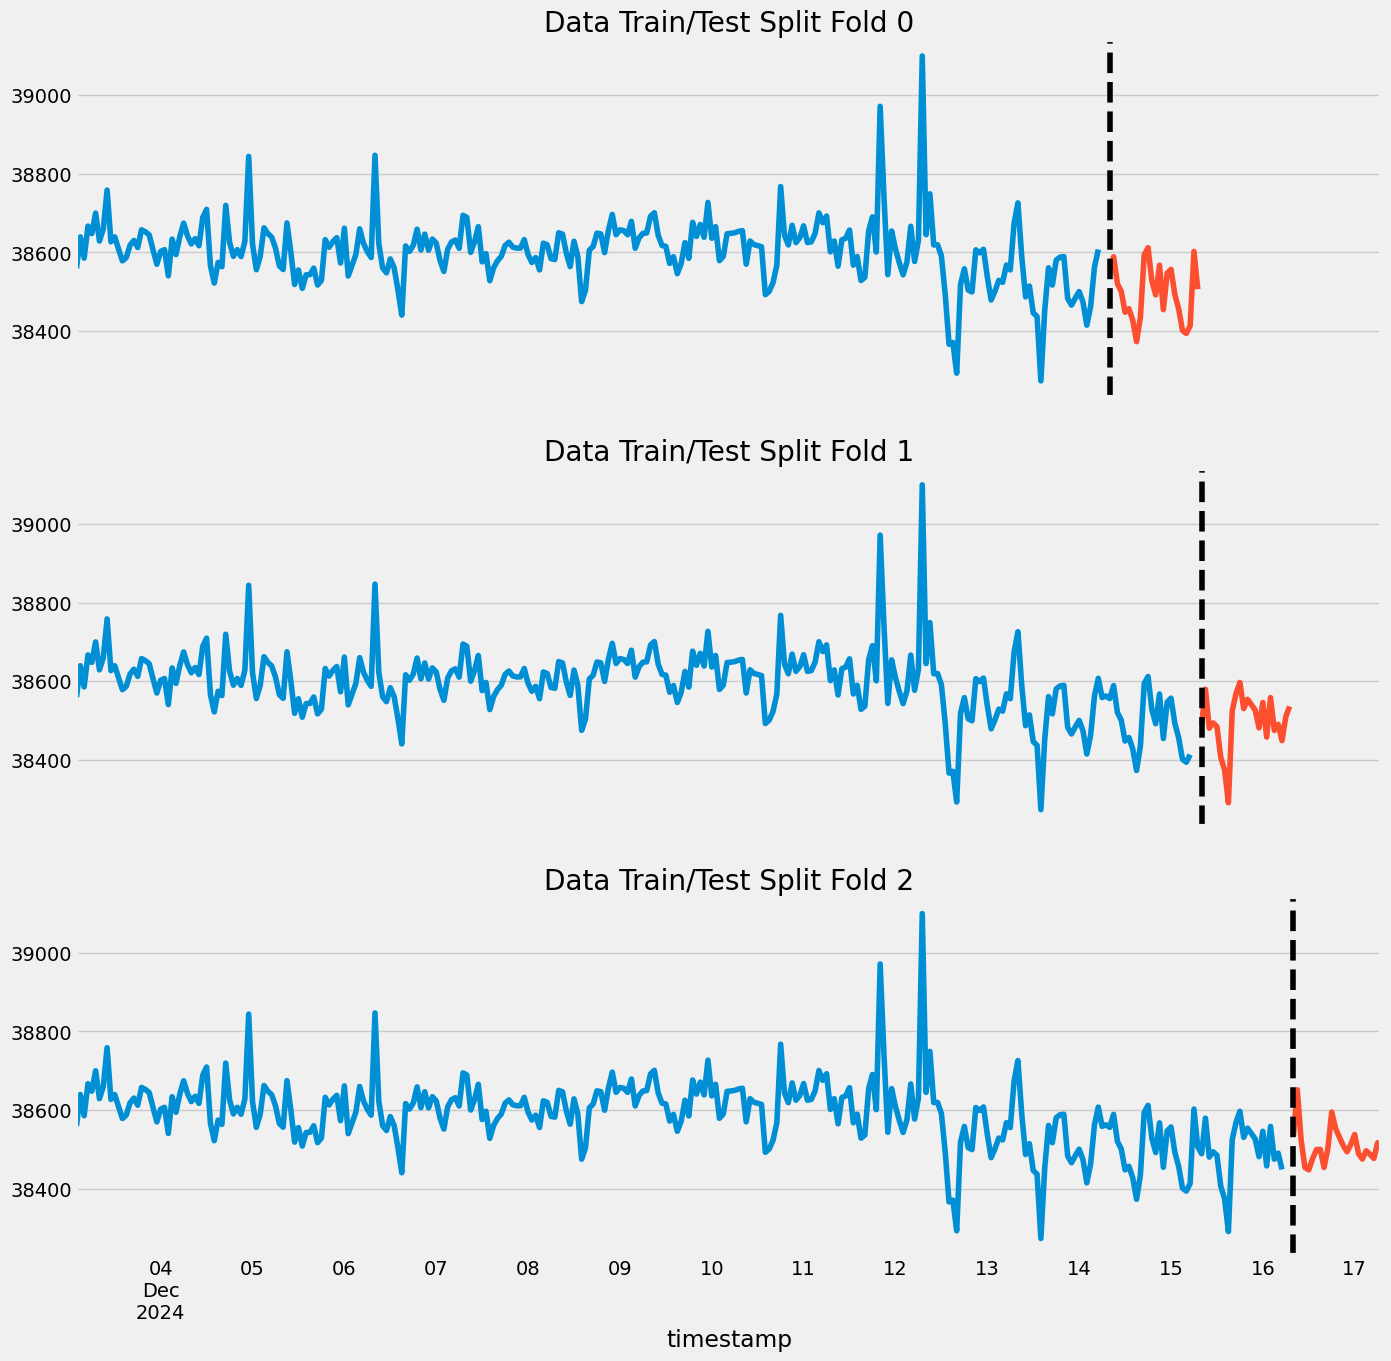

In [141]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    test = train_data.iloc[val_idx]
    train['avgPrice'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['avgPrice'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Now lets train this model and see how these folds work. I will be using some hyperparameter values that may not be optimal and I will save the hyperparameter tuning for the part 2 of this notebook. 

In [142]:
tss = TimeSeriesSplit(n_splits=3, test_size=24, gap=4)
train_data = train_data.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    test = train_data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [ 'hour', 'dayofweek','weekend',
                'lag1']
    TARGET = 'avgPrice'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=1, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.05)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:36679.64814	validation_1-rmse:36573.13010
[100]	validation_0-rmse:234.16779	validation_1-rmse:167.77274
[174]	validation_0-rmse:55.17409	validation_1-rmse:97.15586
[0]	validation_0-rmse:36671.91347	validation_1-rmse:36573.74023
[100]	validation_0-rmse:233.70826	validation_1-rmse:177.20176
[181]	validation_0-rmse:55.21572	validation_1-rmse:74.57898
[0]	validation_0-rmse:36664.07987	validation_1-rmse:36585.10451
[100]	validation_0-rmse:233.64613	validation_1-rmse:178.36410
[173]	validation_0-rmse:58.88631	validation_1-rmse:84.16433


In [287]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 43.4768
Fold scores:[30.95813521573803, 41.69293354393747, 57.77940057876029]


In proper Machine Learning project I would use these fold metrics as idea of how well is our model fitting. With hyperparameter tuning and possibly more features I would like to see average score across folds go down as the model gets more optimal.

For now, lets just train our final model using all the training set data. I will use same parameters and features ad previously but I will drop the n_estimators to 300 as I noticed from crosvalidation that 1000 was way too much. 

In [160]:
data_train = create_features(train_data)

FEATURES = [ 'hour','weekend', 'dayofweek','lag1']
TARGET = 'avgPrice'

X_all = data_train[FEATURES]
y_all = data_train[TARGET]

reg = xgb.XGBRegressor(base_score=1,
                       booster='gbtree',    
                       n_estimators=200,
                       max_depth=3,
                       learning_rate=0.05)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:36657.29747
[100]	validation_0-rmse:232.90193
[199]	validation_0-rmse:56.27609


XGBRegressor(base_score=1, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Next I want to create room for the predictions in the dataset. Lets check the index for our last observation

In [161]:
data_train.index.max()

Timestamp('2024-12-17 07:00:00', freq='H')

date range for our predictions is going to be next 24 hours as 1h frequency

In [162]:
future = pd.date_range('2024-12-17 08:00:00','2024-12-18 07:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
data_train['isFuture'] = False
df_and_future = pd.concat([data_train, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [163]:
future_w_features = df_and_future.query('isFuture').copy()

In [164]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

Now lets print the Predictions and the actual test set in same plot and see if this model is better than Arima models were!

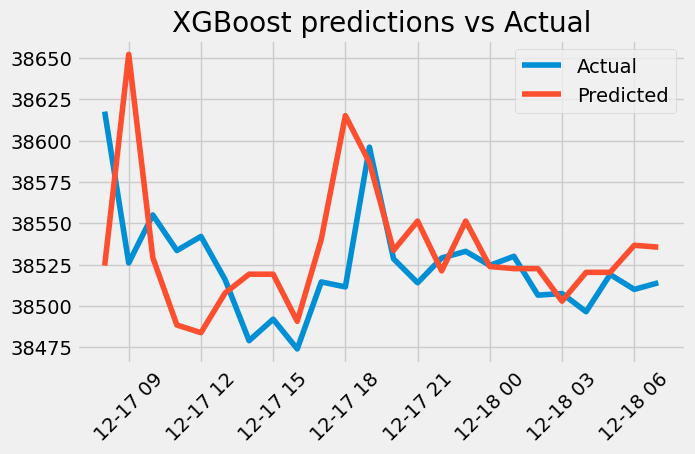

xgboost model RMSE is: 45.05695424232638


In [165]:
plt.figure(figsize=(7,4))
#plt.plot(train, label="Training")
plt.plot(test_data['avgPrice'], label="Actual")
plt.plot(future_w_features['pred'], label="Predicted")
plt.title('XGBoost predictions vs Actual')
plt.legend(loc='upper right')
plt.xticks(rotation = 45)
plt.show()

rmse=mean_squared_error(y_true=test_data['avgPrice'], y_pred=future_w_features['pred'], squared=False)
print("xgboost model RMSE is:", rmse)



It's not perfect, but its getting there! With such simple implementation and limited datat/features we were abe to come up with relatively good prediction. 

Next steps should include tuning the model: adding more features could be a good idea. In perfect world I would acquire more data. Hyperparameters need some tuning. Creating part 2 for this notebook as my next project should be interesting!

In [167]:
#saving dataset for part 2
#df.to_csv(r"C:\Users\Valtteri Kimmo\Downloads\project_data.csv")

#  The End

In this notebook I tackled some simple timeseries forecasting problems with not simple real life data. It turned out ARima family of models was not enough to create model for this dataset. With some machine learning magic and XGBosst heavylifting we managed to estimate model that, considering dataset complexity, lack of data and lack of features, performed suprisingly good.

Major challenges I faced in this project was definitely with the dataset: It was too small to be so complex. It was hard to identify any patterns from the data which resulted poor predictions.

My next steps are to pursue this XGBoost model and try to make it even better. This will be in Part 2.